In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch import linalg as LA
from collections import OrderedDict

In [2]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
class P_Net(nn.Module):
    """ Input format is [b,c,h,w] , it outputs norms of output feature map if final is true 
        else outputs feature map of same formate as input.
        The feature map transforms as [b,n,d,d]->[b,k,d,d]
        where n(on of input planes),k(no of output planes) and d(dim of each planes)
    """
   
    def __init__(self,in_units,out_units,units_dim,share_weights=True,final=False,**kwargs):
        super(P_Net, self).__init__(**kwargs)
        self.n = in_units
        self.k = out_units
        self.d = units_dim
        self.final=final
        self.share_weights = share_weights
        
        # module parameters
        self.R = nn.parameter.Parameter(data=torch.empty(1,self.n,self.k),requires_grad=True)
        nn.init.xavier_uniform_(self.R,gain=1.414) # initializing the weights.

        if(self.share_weights):  
            """ W is 'nk-shared' i.e it is shared among k classes and n feature maps"""
            self.W = nn.parameter.Parameter(data=torch.empty(1,self.d,self.d),requires_grad=True)
            nn.init.xavier_uniform_(self.W,gain=1.414) # initializing the weights.
        

    def forward(self, x):
        #R_nor = F.softmax(self.R, dim=1)
        #R_nor = constrain(self.R)
        if(self.share_weights):
            W_s = torch.tile(self.W,[1,self.n,1,1])
            x = torch.matmul(W_s,x)
        x = torch.unsqueeze(x,dim=2)
        x = torch.tile(x,dims=[1, 1, self.k, 1, 1])
        x = torch.mul(x,torch.reshape(self.R, shape=[1, self.n, self.k, 1, 1]))
        x = torch.sum(x,dim=1)
        x = F.relu(x)
        if(self.final):
            x = LA.matrix_norm(x+1e-7,ord='fro',dim=(-2,-1))
        return x

class conv_block(nn.Module):

      def __init__(self, in_channels=12,out_channels=12):
          super(conv_block,self).__init__()
          self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1,padding='same', bias = False)
          self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,padding='same', bias = False)
          self.relu = nn.ReLU(inplace=True)
          self.bn1 = nn.BatchNorm2d(in_channels)
          self.bn2 = nn.BatchNorm2d(out_channels)

      def forward(self, x):
          x = self.conv1(self.relu(self.bn1(x)))
          x = self.conv3(self.relu(self.bn2(x)))
          return x

          
class Transition(nn.Module):

      def __init__(self, in_channels=12, out_channels =12):
          super(Transition,self).__init__()
          self.in_channels = in_channels
          self.out_channels = out_channels

          self.conv1 = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=1,padding='same', bias = False)
          self.bn1 = nn.BatchNorm2d(self.in_channels)

      def forward(self, x):
          x = self.conv1(F.relu(self.bn1(x),inplace = True))
          x = F.avg_pool2d(x, 2, stride=2)
          #self.outplane_dim = x.shape[-1]
          return x


class DenseBlock(nn.ModuleDict):

    def __init__(
        self,
        num_layers: int,
        num_input_features: int,
        growth_rate: int,
    ) -> None:
        super(DenseBlock,self).__init__()
        for i in range(num_layers):
            layer = conv_block(
                in_channels = num_input_features + i * growth_rate,
                out_channels = growth_rate
            )
            self.add_module("conv_block%d" % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(torch.cat(features, 1))
            features.append(new_features)
        return torch.cat(features, 1)


class DenseNet(nn.Module):
    
    def __init__(
        self,
        growth_rate: int = 12,
        block_config = [6, 12, 24, 16],
        num_init_features: int = 32,
        in_feature_dim: int = 32,
        num_classes: int = 10,
        classifier: str = 'Linear'
        ):

        super(DenseNet,self).__init__()
        
        self.final = classifier
      
        # First convolution
        self.features = nn.Sequential(
            OrderedDict(
                [
                    ("conv0", nn.Conv2d(3, num_init_features, kernel_size=3, stride=2, padding=1, bias=False)),
                    ("norm0", nn.BatchNorm2d(num_init_features)),
                    ("relu0", nn.ReLU(inplace=True)),
                ]
            )
        )
      
        # Each denseblock
        feature_dim = in_feature_dim//2 #due to stride 2 in conv1.
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                growth_rate=growth_rate
            )
            self.features.add_module("denseblock%d" % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = Transition(in_channels=num_features, out_channels=num_features // 2)
                self.features.add_module("transition%d" % (i + 1), trans)
                num_features = num_features // 2
                feature_dim = feature_dim // 2

        # Final batch norm
        self.features.add_module("norm5", nn.BatchNorm2d(num_features))

        # classifier layer
        if(classifier == 'Linear'):
            self.classifier = nn.Linear(num_features, num_classes)
        
        if(classifier == 'P_Net'):
            self.classifier = P_Net(num_features, num_classes, feature_dim, final=True)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features,inplace = True)

        if(self.final=='Linear'):
            out = F.adaptive_avg_pool2d(out, (1, 1))
            out = torch.flatten(out, 1)
        elif(self.final=='P_Net'):
            out = self.classifier(out)
        return out


In [5]:
data_path = '../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/'

from torchvision import datasets, transforms

transform = transforms.Compose([transforms.Resize((128,128)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

dataset = datasets.ImageFolder(data_path, transform=transform)

train_dataset,test_dataset = torch.utils.data.random_split(dataset,[9000,1000])

In [6]:
print(dataset.classes)
n_classes = len(dataset.classes)

['colon_aca', 'colon_n']


In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=128,num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=128,num_workers=2)

In [8]:
model = DenseNet(growth_rate = 24,
                block_config = [6, 12, 24, 16],
                   num_init_features= 32,
                   in_feature_dim= 128,
                   num_classes= n_classes,
                   classifier='P_Net')

x = torch.randn(1,3,128,128)
output = model(x)
print(f'model output shape: {output.shape}.')

model = model.to(device)

total_params=sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total trainable parameters: {total_params}.')
#summary(model,(3,32,32))

loss = nn.CrossEntropyLoss()

model output shape: torch.Size([1, 2]).
Total trainable parameters: 1294488.


In [9]:
class Model_trainer():

    def __init__(self,classes):

        self.test_loss = []
        self.train_loss = []
        self.classes = classes
        self.prediction: dict
        self.prevepoch_loss = float('inf')

    def train_loop(self, dataloader, model, loss_fn, optimizer):
        model.train()
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        train_loss = 0
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)
            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)
            train_loss += loss.item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= num_batches
        return train_loss

    def test_loop(self, dataloader, model, loss_fn):
        model.eval()

        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        test_loss = 0

        y_pred = []
        y_true = []

        with torch.no_grad():
            for X, y in dataloader:
                X = X.to(device)
                y = y.to(device)
                pred = model(X)
                test_loss += loss_fn(pred, y).item()

                y_pred.append(torch.argmax(pred,dim=-1).cpu().numpy())
                y_true.append(y.cpu().numpy())

        test_loss /= num_batches
        return test_loss,{'y_pred':y_pred,'y_true':y_true}


    def fit(self,trainloader, testloader, model, loss_fn, optimizer, scheduler, epochs=30, verbose=False):
        for t in range(epochs):
            train_loss = self.train_loop(trainloader, model, loss_fn, optimizer)
            test_loss,prediction = self.test_loop(testloader,model, loss)
            scheduler.step(test_loss)
            self.train_loss.append(train_loss)
            self.test_loss.append(test_loss)
            if(self.prevepoch_loss > test_loss):
                self.prediction = prediction
                if(verbose):
                  print('saving model predictions')
            self.prevepoch_loss = test_loss
            print('Epoch: %d, Train Loss: %.5f, Test Loss: %.5f'%(t+1,train_loss,test_loss))

        self.prediction['y_pred'] = np.concatenate(self.prediction['y_pred'])
        self.prediction['y_true'] = np.concatenate(self.prediction['y_true'])
        return {'Train_loss':self.train_loss,'Test_loss':self.test_loss,'class_label':self.classes},self.prediction

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                  mode='min', 
                                                  factor=0.5, 
                                                  patience=2, 
                                                  threshold=0.001,
                                                  min_lr=1e-7,
                                                  verbose=True)
model_trainer = Model_trainer(dataset.classes)

In [11]:
history,prediction = model_trainer.fit(train_loader,test_loader,model,loss,optimizer,scheduler,epochs=60)

Epoch: 1, Train Loss: 0.26653, Test Loss: 0.02330
Epoch: 2, Train Loss: 0.01926, Test Loss: 0.00763
Epoch: 3, Train Loss: 0.00476, Test Loss: 0.01139
Epoch: 4, Train Loss: 0.00868, Test Loss: 0.04452
Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.
Epoch: 5, Train Loss: 0.01364, Test Loss: 0.06453
Epoch: 6, Train Loss: 0.00169, Test Loss: 0.00143
Epoch: 7, Train Loss: 0.00046, Test Loss: 0.00391
Epoch: 8, Train Loss: 0.00032, Test Loss: 0.00234
Epoch 00009: reducing learning rate of group 0 to 2.5000e-04.
Epoch: 9, Train Loss: 0.00010, Test Loss: 0.00258
Epoch: 10, Train Loss: 0.00018, Test Loss: 0.00202
Epoch: 11, Train Loss: 0.00010, Test Loss: 0.00205
Epoch: 12, Train Loss: 0.00008, Test Loss: 0.00141
Epoch: 13, Train Loss: 0.00005, Test Loss: 0.00161
Epoch: 14, Train Loss: 0.00009, Test Loss: 0.00177
Epoch 00015: reducing learning rate of group 0 to 1.2500e-04.
Epoch: 15, Train Loss: 0.00009, Test Loss: 0.00172
Epoch: 16, Train Loss: 0.00004, Test Loss: 0.00129
Epoch: 

In [12]:
print(metrics.classification_report(prediction['y_true'],prediction['y_pred'], digits=3))

              precision    recall  f1-score   support

           0      1.000     0.998     0.999       501
           1      0.998     1.000     0.999       499

    accuracy                          0.999      1000
   macro avg      0.999     0.999     0.999      1000
weighted avg      0.999     0.999     0.999      1000



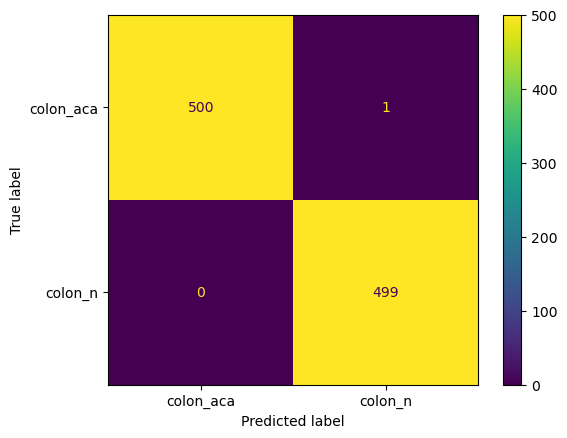

In [13]:
confusion_matrix = metrics.confusion_matrix(prediction['y_true'],prediction['y_pred'])
img = metrics.ConfusionMatrixDisplay(confusion_matrix,display_labels=history['class_label'])
img.plot()
plt.show()

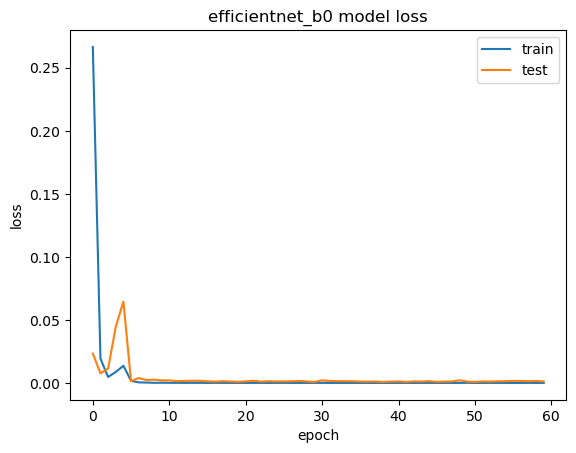

In [14]:
plt.plot(history['Train_loss'])
plt.plot(history['Test_loss'])
plt.title('efficientnet_b0 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [15]:
with open('../working/dens_colon_history.pickle', 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../working/dens_colon_prediction.pickle', 'wb') as handle:
    pickle.dump(prediction, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [16]:
# with open('colon_prediction.pickle', 'rb') as handle:
#     prediction = pickle.load(handle)
# with open('colon_history_.pickle', 'rb') as handle:
#     history = pickle.load(handle)